Given the loan default dataset, apply the following algorithms to find the best classifier:

1. K-Nearest Neighbors
2. Decision Tree
3. SVM
4. Logistic Regression

Load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-08-22 19:18:20--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-08-22 19:18:20 (14.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



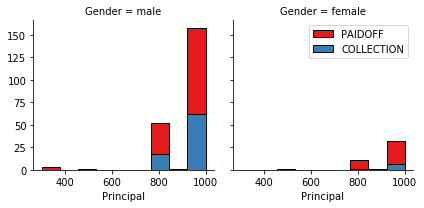

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

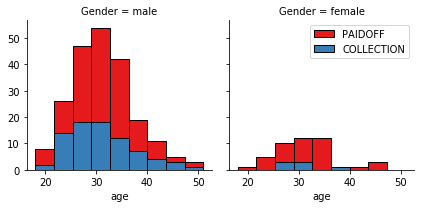

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

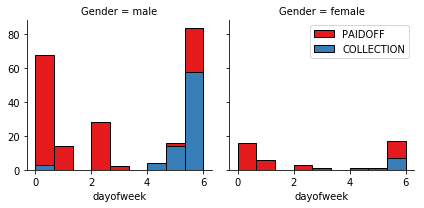

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [17]:
X_train = Feature
X_train[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


Identify training labels

In [18]:
y_train = df['loan_status'].values
y_train[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X_train= preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_train[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

As mentioned above, I will use the following algorithms:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



Note:
- I could change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.


## Train the classifiers

# K Nearest Neighbor(KNN)


In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

# Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier

loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Support Vector Machine

In [24]:
from sklearn import svm
loan_svm = svm.SVC(kernel='rbf', gamma='auto')
loan_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
loan_LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
loan_LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

In [26]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [27]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-08-22 19:21:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-08-22 19:21:01 (467 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [28]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [29]:
test_df.shape

(54, 10)

In [30]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,1
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,0
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,1
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,0
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,0


In [31]:
test_df['dayofweek'] = df['effective_date'].dt.dayofweek

In [32]:
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,0,3,0
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,1,3,0
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,0,4,1
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,0,4,1


In [33]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
0       PAIDOFF        0.744186
        COLLECTION     0.255814
1       PAIDOFF        0.727273
        COLLECTION     0.272727
Name: loan_status, dtype: float64

In [34]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [35]:
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [36]:
# One-hot-encode test set
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test_feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [37]:
X_test = test_feature
X_test[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [38]:
y_test = test_df['loan_status'].values
y_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [39]:
# Import confusion matrix to evaluate performance
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [40]:
# Function to plot confusion matrix and normalize data if necessary by setting it to "true"
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### KNN Evaluation

In [41]:
# Make predictions
yhat_knn = neigh.predict(X_test)
yhat_knn [0:5]

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION'],
      dtype=object)

In [42]:
# Check accuracy of model
from sklearn import metrics
print("Training Accuracy: ","%.2f" % metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test Accuracy: ","%.2f" % metrics.accuracy_score(y_test, yhat_knn))

Training Accuracy:  0.82
Test Accuracy:  0.48


In [43]:
# Calculate Jaccard Index
from sklearn.metrics import jaccard_similarity_score
print("Jaccard coeficient: ","%.2f" %jaccard_similarity_score(y_test, yhat_knn))

Jaccard coeficient:  0.48


              precision    recall  f1-score   support

  COLLECTION       0.15      0.21      0.18        14
     PAIDOFF       0.68      0.57      0.62        40

   micro avg       0.48      0.48      0.48        54
   macro avg       0.41      0.39      0.40        54
weighted avg       0.54      0.48      0.51        54

Confusion matrix, without normalization
[[ 3 11]
 [17 23]]


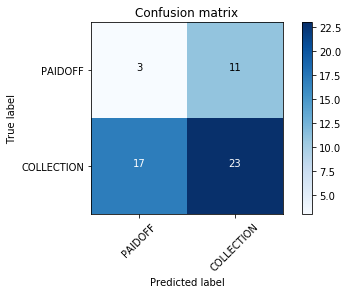

In [44]:
# Compute confusion matrix
cnf_matrix_knn = confusion_matrix(y_test, yhat_knn)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_knn))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_knn, classes=["PAIDOFF", "COLLECTION"],normalize= False,  title='Confusion matrix')

#### I want to evaluate the model using different 'k' values

In [45]:
# Try different Ks
# In this case, we want to try up to K=10
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_knn=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_knn)

    
    std_acc[n-1]=np.std(yhat_knn==y_test)/np.sqrt(yhat_knn.shape[0])

mean_acc

array([0.54, 0.26, 0.61, 0.48, 0.72, 0.72, 0.74, 0.74, 0.74])

In [46]:
print(min(mean_acc))
print(max(mean_acc))

0.25925925925925924
0.7407407407407407


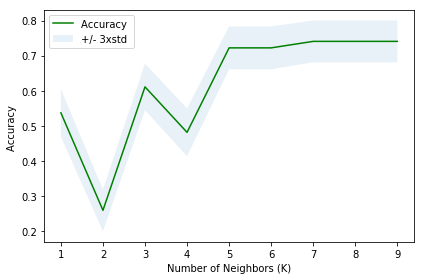

In [47]:
# Plot accuracy of different numbers of neighbors

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

K=7 has the highest test accuracy

## Tree Evaluation

In [48]:
#Prediction
predTree = loanTree.predict(X_test)

In [49]:
# Compare prediction and actual results
print (predTree [0:5])
print (y_test [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [50]:
# Evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.7407407407407407


In [51]:
# Calculate Jaccard Index
from sklearn.metrics import jaccard_similarity_score
print("Jaccard coeficient: ","%.2f" %jaccard_similarity_score(y_test, predTree))

Jaccard coeficient:  0.74


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      1.00      0.85        40

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54

Confusion matrix, without normalization
[[ 0 14]
 [ 0 40]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


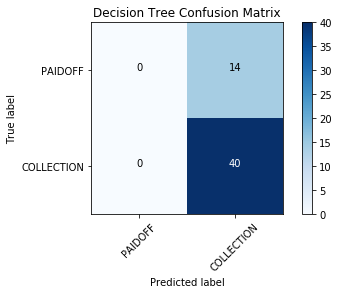

In [52]:
# Compute confusion matrix
cnf_matrix_tree = confusion_matrix(y_test, predTree)
np.set_printoptions(precision=2)

print (classification_report(y_test, predTree))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_tree, classes=["PAIDOFF", "COLLECTION"],normalize= False,  title='Decision Tree Confusion Matrix')

## Visualize tree 

In [53]:
!pip install pydotplus

In [54]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus

In [55]:
# Create labels
X_labels = list(Feature.columns)

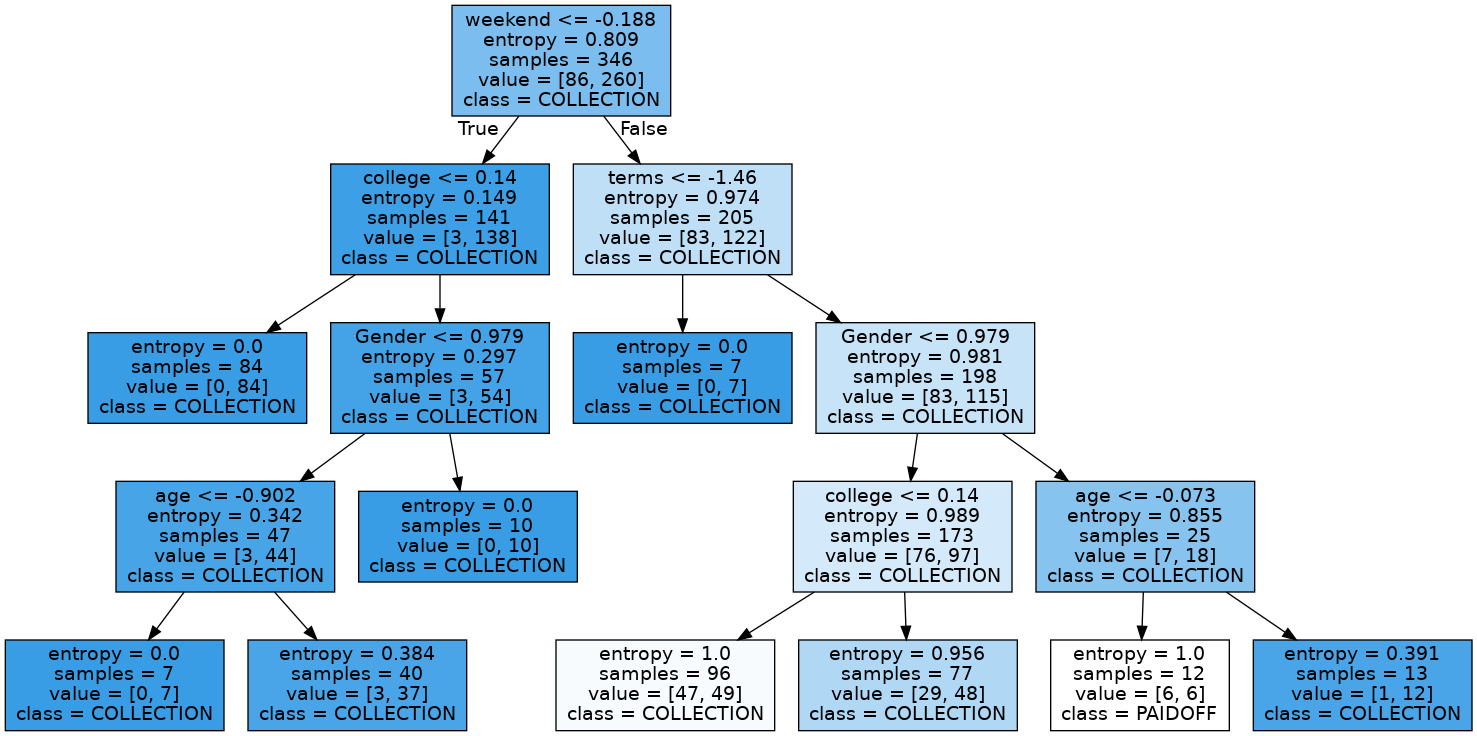

In [56]:
# Create DOT data
dot_data = tree.export_graphviz(loanTree, out_file=None,filled=True,
                                feature_names=X_labels,  
                                class_names=["PAIDOFF", "COLLECTION"])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## SVM Evaluation

In [57]:
# Make predictions
yhat_svm = loan_svm.predict(X_test)
yhat_svm [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      1.00      0.85        40

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54

Confusion matrix, without normalization
[[ 0 14]
 [ 0 40]]


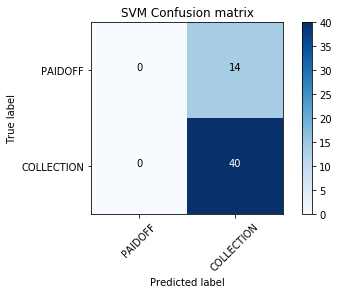

In [58]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_svm)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_svm))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["PAIDOFF", "COLLECTION"],normalize= False,  title='SVM Confusion matrix')

In [59]:
# See Jaccard Similarity Score
from sklearn.metrics import jaccard_similarity_score
print("Jaccard score: %.2f" % jaccard_similarity_score(y_test, yhat_svm))

Jaccard score: 0.74


In [60]:
# See F1 score
from sklearn.metrics import f1_score
print("Avg F1-score: %.2f" % f1_score(y_test, yhat_svm, average='weighted'))

Avg F1-score: 0.63


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Logistic Regression Evaluation

In [61]:
# Predict using Test Dataset
yhat_LR = np.asarray(loan_LR.predict(X_test))
yhat_LR [0:5]

array(['COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION'], dtype=object)

In [62]:
# Calculate the probability 
yhat_prob = loan_LR.predict_proba(X_test)
yhat_prob

array([[1.00e+00, 5.16e-16],
       [1.00e+00, 6.22e-05],
       [1.00e+00, 4.36e-16],
       [1.00e+00, 2.01e-16],
       [1.00e+00, 5.77e-13],
       [1.00e+00, 2.06e-11],
       [1.00e+00, 4.80e-16],
       [1.00e+00, 2.24e-16],
       [1.00e+00, 6.13e-13],
       [1.00e+00, 6.39e-16],
       [1.00e+00, 5.10e-13],
       [1.00e+00, 4.45e-05],
       [1.00e+00, 2.19e-16],
       [1.00e+00, 2.78e-16],
       [1.00e+00, 2.67e-16],
       [1.00e+00, 2.35e-16],
       [1.00e+00, 7.85e-13],
       [1.00e+00, 9.84e-16],
       [1.00e+00, 4.82e-16],
       [1.00e+00, 8.39e-16],
       [1.00e+00, 2.20e-16],
       [1.00e+00, 8.03e-16],
       [1.00e+00, 4.54e-05],
       [1.00e+00, 5.36e-16],
       [1.00e+00, 4.89e-16],
       [1.00e+00, 2.32e-13],
       [1.00e+00, 2.62e-16],
       [1.00e+00, 3.13e-16],
       [1.00e+00, 2.29e-16],
       [1.00e+00, 2.15e-16],
       [1.00e+00, 2.15e-16],
       [1.00e+00, 6.01e-16],
       [1.00e+00, 2.15e-16],
       [1.00e+00, 2.20e-16],
       [1.00e+

In [63]:
# Check accuracy of model
from sklearn import metrics
print("Train set Accuracy: ","%.2f" % metrics.accuracy_score(y_train, loan_LR.predict(X_train)))
print("Test set Accuracy: ","%.2f" % metrics.accuracy_score(y_test, yhat_LR))

Train set Accuracy:  0.75
Test set Accuracy:  0.26


In [64]:
# Calculate Jaccard Index
from sklearn.metrics import jaccard_similarity_score
print('Jaccard Index: '"%.2f" %jaccard_similarity_score(y_test, yhat_LR))

Jaccard Index: 0.26


In [65]:
# See F1 score
from sklearn.metrics import f1_score
print("Avg F1-score: %.2f" % f1_score(y_test, yhat_LR, average='weighted'))

Avg F1-score: 0.11


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [66]:
# Calculate LogLoss
from sklearn.metrics import log_loss
print('LogLoss: ',"%.2f" % log_loss(y_test, yhat_prob))

LogLoss:  23.34


In [67]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

results = confusion_matrix(y_test, yhat_LR) 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',"%.2f" %accuracy_score(y_test, yhat_LR))
print ('Report : ')
print (classification_report(y_test, yhat_LR))

Confusion Matrix :
[[14  0]
 [40  0]]
Accuracy Score : 0.26
Report : 
              precision    recall  f1-score   support

  COLLECTION       0.26      1.00      0.41        14
     PAIDOFF       0.00      0.00      0.00        40

   micro avg       0.26      0.26      0.26        54
   macro avg       0.13      0.50      0.21        54
weighted avg       0.07      0.26      0.11        54



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.48    | 0.51     | NA      |
| Decision Tree      | 0.74    | 0.63     | NA      |
| SVM                | 0.74    | 0.63     | NA      |
| LogisticRegression | 0.26    | 0.11     | 23.34   |